photoshoot/IMG_7999.JPG


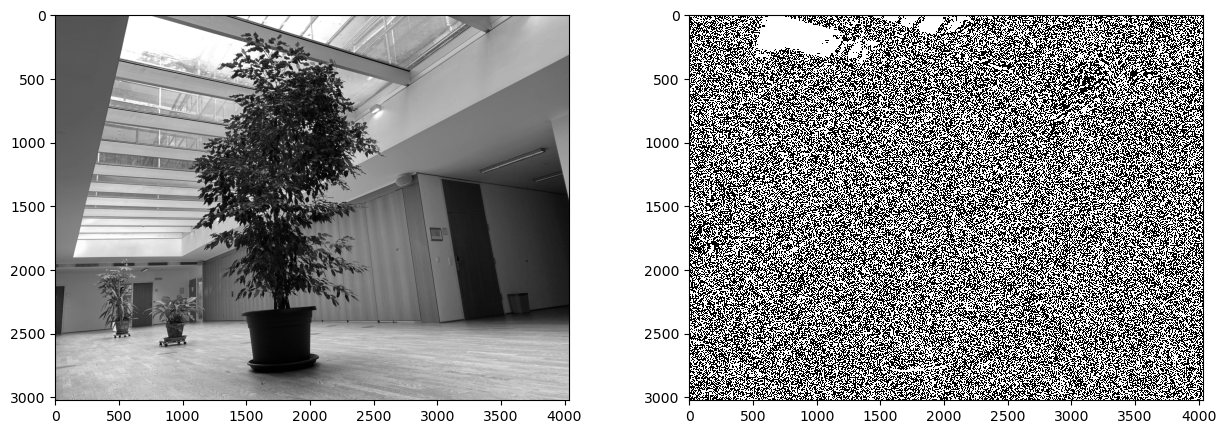

photoshoot/IMG_8007.JPG


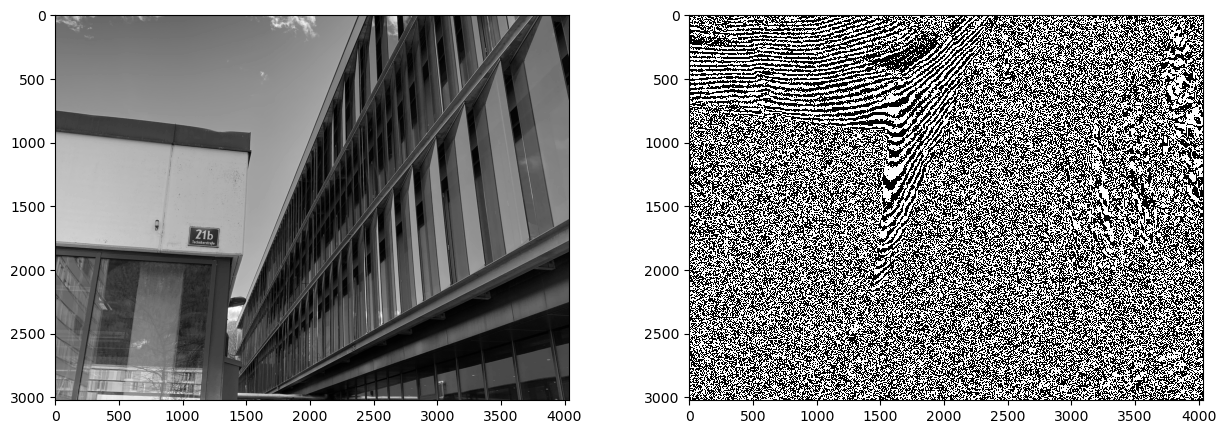

photoshoot/IMG_8004.JPG


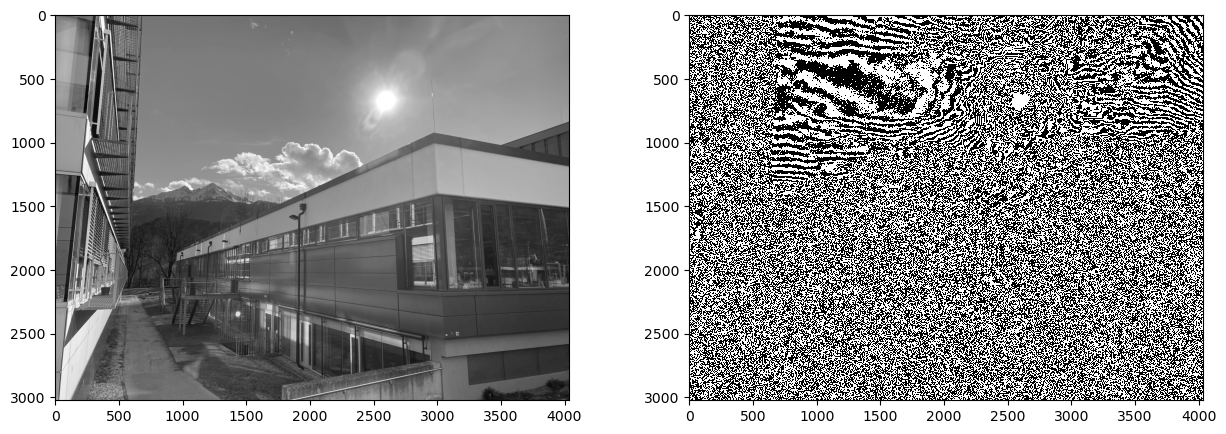

photoshoot/IMG_8032.JPG


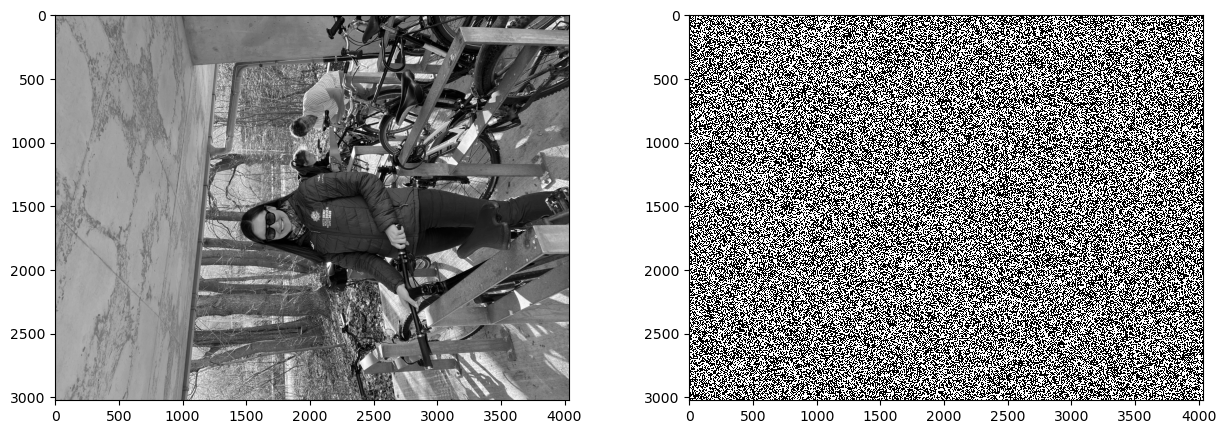

photoshoot/IMG_8008.JPG


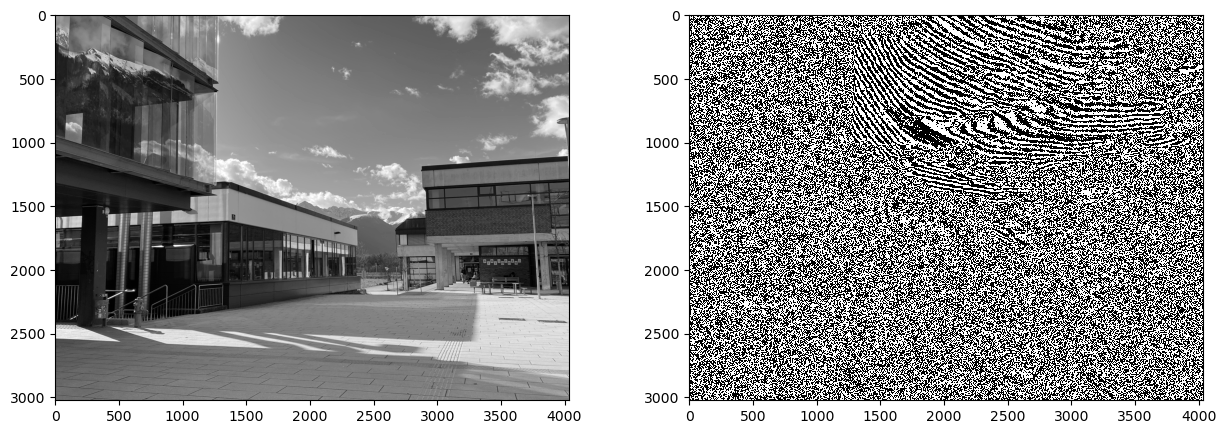

photoshoot/GOPR0014.JPG


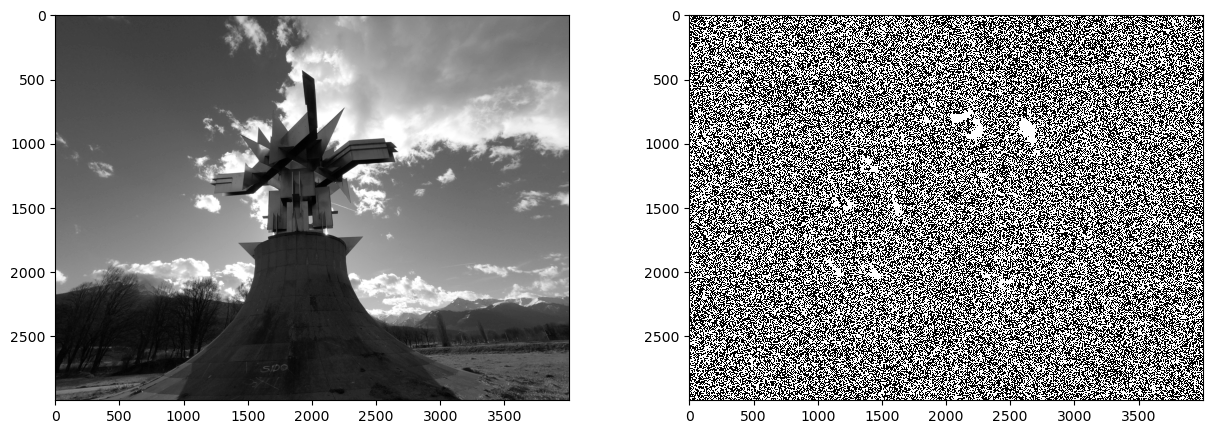

photoshoot/GOPR0011.JPG


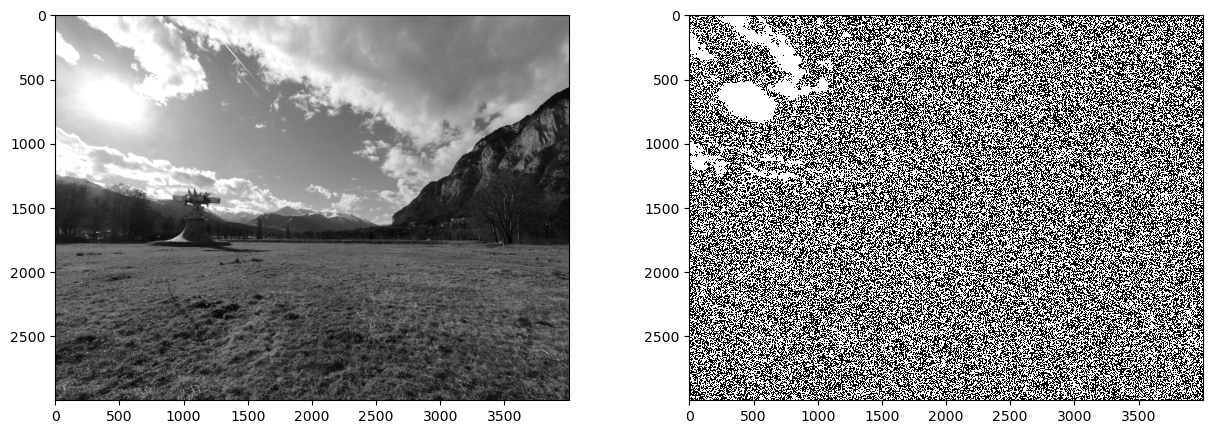

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

for fname in glob.glob('photoshoot/*.JPG'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    x = np.array(Image.open(fname).convert('L'))
    print(fname)
    ax[0].imshow(x, cmap='gray')
    ax[1].imshow(x & 1, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    plt.show()
    exit

In [2]:
def embed_lsbr(cover: np.ndarray, message: bytes, key: int = None) -> np.ndarray:
    # encode
    message_bits = []
    for bit in message:
        for i in range(8):
            message_bits.append((bit >> i) & 1) # turn characters into 0s and 1s
    message_bits = np.array(message_bits)

    # permuted walk-through
    perm = np.linspace(0, cover.size-1, cover.size, dtype='int64')
    if key is not None:
        rng = np.random.default_rng(key) # <- here we choose the seed
        perm = rng.permutation(perm) # <- this shuffles our order around
        
    # embed message
    stego = cover.copy()
    for i, it in enumerate(perm):
        # message exhausted (we are at end of message)
        if len(message_bits) <= i:
            break
        
        # get index (x- and y-coordinate of pixel we want to change)
        idx = it // cover.shape[1], it % cover.shape[1]
    
        # make change
        stego[idx] &= ~0 << 1
        stego[idx] |= message_bits[i]
    
    return stego

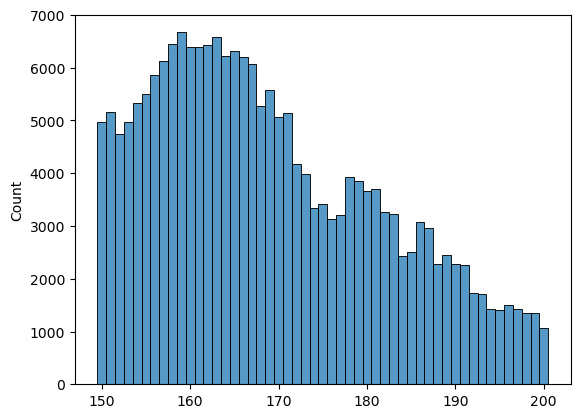

In [4]:
import seaborn as sns
sns.histplot(y.flatten(), binrange=(150, 200), discrete=True);  # stego histogram

In [5]:
def extract_lsbr(stego: np.ndarray, num: int = None, key: int = None) -> str:
    # permuted walk-through
    perm = np.linspace(0, stego.size-1, stego.size, dtype='int64')
    if key is not None:
        rng = np.random.default_rng(key) # <- here we choose the seed
        perm = rng.permutation(perm) # <- this shuffles our order around
    
    # Gather LSB bits along pseudorandom path
    message_bits_extracted = []
    for i, it in enumerate(perm): # <- walk along the same pseudorandom path
        # get index (x- and y-coordinate)
        idx = it // stego.shape[1], it % stego.shape[1]
        
        if i // 8 + 8 == num:
            message_bits_extracted += [0]*8
        
        # get message bit
        message_bits_extracted.append(stego[idx] & 1)
        
        ## check end
        #if (i + 1) % 8 == 0:
        #    if all([b == 0 for b in message_bits_extracted[-8:]]):
        #        break
        
    # convert to characters
    message_bytes_extracted = b''
    for i in range(len(message_bits_extracted)//8):
        char_bits = list(message_bits_extracted[i*8:(i+1)*8])

        # decode the byte
        byte = 0
        for i, bit in enumerate(char_bits):
            byte |= bit << i
        message_bytes_extracted += int(byte).to_bytes(1, byteorder='big')
    
    return message_bytes_extracted
    ## remove tracing zero
    #try:
    #    message = bytes.decode(message_bytes_extracted, 'ascii').split('\0')[0]
    #    return message
    #except UnicodeDecodeError:
    #    raise RuntimeError('extraction failed, perhaps wrong key?')

In [6]:
import zlib

# images for exercise 1
#
x = np.array(Image.open('photoshoot/IMG_8032.JPG').convert('L'))
x = np.rot90(x, k=3)[1200:3000,200:2900]
Image.fromarray(x).save('theft.png')

# images for exercise 2
#
x = np.array(Image.open('photoshoot/IMG_8007.JPG').convert('L'))
Image.fromarray(x).save('t21b.png')
#
x = np.array(Image.open('photoshoot/IMG_8008.JPG').convert('L'))
Image.fromarray(x).save('technik.png')

# images for exercise 3
#
x = np.array(Image.open('photoshoot/IMG_8004.JPG').convert('L'))
x = x[1000:2000, 500:1500]
Image.fromarray(x).save('nockspitze.png')
#
x = np.array(Image.open('photoshoot/IMG_7999.JPG').convert('L'))
x = x[-2000:-1000, 1000:2000]
message = b'Hi Verena!\nSorry again that you lost the key from your bike.\nLet\'s meet today by the bike stand to cut the lock.\n\nMartin.'
message_c = zlib.compress(message)
y = embed_lsbr(x, message_c)
Image.fromarray(y).save('t21a.png')
#
#
x = np.array(Image.open('photoshoot/GOPR0011.JPG').convert('L'))
x = x[500:1500, -1000:]
N = x.size//8-8
with open('t8.shakespeare.txt', 'rb') as fp:
    shakespeare = fp.read()[10455:]
shakespeare_c = zlib.compress(shakespeare)
y = embed_lsbr(x, shakespeare_c[:N], key=42)
Image.fromarray(y).save('martinswand.png')
#
x = np.array(Image.open('photoshoot/GOPR0014.JPG').convert('L'))
Image.fromarray(x).save('statue.png')

In [7]:
bmessage = extract_lsbr(y, key=42)
zlib.decompressobj().decompress(bmessage)

b'\n1609\n\nTHE SONNETS\n\nby William Shakespeare\n\n\n\n                     1\n  From fairest creatures we desire increase,\n  That thereby beauty\'s rose might never die,\n  But as the riper should by time decease,\n  His tender heir might bear his memory:\n  But thou contracted to thine own bright eyes,\n  Feed\'st thy light\'s flame with self-substantial fuel,\n  Making a famine where abundance lies,\n  Thy self thy foe, to thy sweet self too cruel:\n  Thou that art now the world\'s fresh ornament,\n  And only herald to the gaudy spring,\n  Within thine own bud buriest thy content,\n  And tender churl mak\'st waste in niggarding:\n    Pity the world, or else this glutton be,\n    To eat the world\'s due, by the grave and thee.\n\n\n                     2\n  When forty winters shall besiege thy brow,\n  And dig deep trenches in thy beauty\'s field,\n  Thy youth\'s proud livery so gazed on now,\n  Will be a tattered weed of small worth held:  \n  Then being asked, where all thy beau

In [8]:
# GIFs to base64
import base64
for fname in ['coin', 'trump', 'monalisa']:
    with open(f'{fname}.gif', 'rb') as image_file:
        encoded_string = base64.b64encode(image_file.read())
    with open(f'{fname}.txt', 'wb') as f:
        f.write(b'<center>\n<img src="data:image/gif;base64,')
        f.write(encoded_string)
        f.write(b'"><br />\n<tiny>Source: <a href="TODO">https://giphy.com/</a></tiny>\n</center>')

FileNotFoundError: [Errno 2] No such file or directory: 'coin.gif'

In [10]:
y = embed_lsbr(
    x,
    b"hello, how are you. this is a secret message. I hope it will not get into wrong hands.",
    key=12345,
)
print((x != y).sum())
print(np.abs(x.astype('int') - y).max())
message = extract_lsbr(y, key=12345)
print(message)

360
1


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import base64
matrix = np.array([  
    [ 80, 180, 121],
    [161, 100, 200],
], dtype='uint8')
plt.imshow(matrix, cmap='gray', vmin=0, vmax=255)
#Add text over image
eq0 = r"$01010000$"
eq1 = r"$10110100$"
eq2 = r"$01111001$"
eq3 = r"$10100001$"
eq4 = r"$01100100$"
eq5 = r"$11001000$"
plt.text(-0.30, 0.05, eq0, {'color': '0', 'fontsize': 13})
plt.text(0.7, 0.05, eq1, {'color': '0', 'fontsize': 13})
plt.text(1.7, 0.05, eq2, {'color': '0', 'fontsize': 13})
plt.text(-0.3, 1.05, eq3, {'color': '0', 'fontsize': 13})
plt.text(0.7, 1.05, eq4, {'color': '0', 'fontsize': 13})
plt.text(1.7, 1.05, eq5, {'color': '0', 'fontsize': 13})
plt.axis('off')

import tempfile
with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
    pass
tmp_name = "grid.png"
plt.savefig(tmp_name, bbox_inches='tight')
with open(tmp_name, 'rb') as image_file:
    encoded_string = base64.b64encode(image_file.read())
with open(f'grid.txt', 'wb') as f:
    f.write(b'<center>\n<img src="data:image/png;base64,')
    f.write(encoded_string)
    f.write(b'">\n</center>')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import base64
matrix = np.array([  
    [ 80, 180, 121],
    [161, 100, 200],
], dtype='uint8');
plt.imshow(matrix, cmap='gray', vmin=0, vmax=255);
#Add text over image
eq0 = r"$0101000$";
eq0lsb = r"$0$";
eq1 = r"$1011010$";
eq1lsb = r"$1$";
eq2 = r"$0111100$";
eq2lsb = r"$1$";
eq3 = r"$1010000$";
eq3lsb = r"$0$";
eq4 = r"$0110010$";
eq4lsb = r"$1$";
eq5 = r"$1100100$";
eq5lsb = r"$0$";
plt.text(-0.30, 0.05, eq0, {'color': '0', 'fontsize': 13});
plt.text(0.23, 0.05, eq0lsb, {'color': 'C0', 'fontsize': 13});
plt.text(0.7, 0.05, eq1, {'color': '0', 'fontsize': 13});
plt.text(1.23, 0.05, eq1lsb, {'color': 'C3', 'fontsize': 13});
plt.text(1.7, 0.05, eq2, {'color': '0', 'fontsize': 13});
plt.text(2.23, 0.05, eq2lsb, {'color': 'C2', 'fontsize': 13});
plt.text(-0.3, 1.05, eq3, {'color': '0', 'fontsize': 13});
plt.text(0.23, 1.05, eq3lsb, {'color': 'C4', 'fontsize': 13});
plt.text(0.7, 1.05, eq4, {'color': '0', 'fontsize': 13});
plt.text(1.23, 1.05, eq4lsb, {'color': 'C6', 'fontsize': 13});
plt.text(1.7, 1.05, eq5, {'color': '0', 'fontsize': 13});
plt.text(2.23, 1.05, eq5lsb, {'color': 'C1', 'fontsize': 13});
plt.axis('off')

import tempfile
with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
    pass
tmp_name = "colorgrid.png"
plt.savefig(tmp_name, bbox_inches='tight')
with open(tmp_name, 'rb') as image_file:
    encoded_string = base64.b64encode(image_file.read())
with open(f'colorgrid.txt', 'wb') as f:
    f.write(b'<center>\n<img src="data:image/png;base64,')
    f.write(encoded_string)
    f.write(b'">\n</center>')


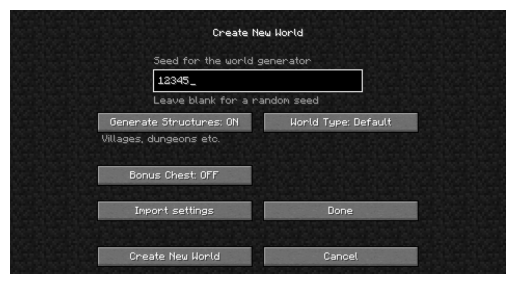

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import base64
from PIL import Image
img = Image.open('../img/minecraft.png')  # load image
minecraft = np.array(img.convert('L'))  # PIL to numpy
plt.imshow(minecraft,cmap = "gray");
plt.axis('off')

import tempfile
with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
    plt.savefig(tmp.name, bbox_inches='tight')
    with open(tmp.name, 'rb') as image_file:
        encoded_string = base64.b64encode(image_file.read())
with open(f'minecraft.txt', 'wb') as f:
    f.write(b'<center>\n<img src="data:image/png;base64,')
    f.write(encoded_string)
    f.write(b'">\n</center>')